# Optical character recognition
This project demonstrates how to predict character from a 5x5 matrix, represented as as vector of n=25 using an only mathematical approach. Only the charracters J, D and N will be used for recognition. Inner products, correlation matrices and dot products are at the center of this project.
By Jaden van Rijswijk.

In [1]:
import numpy as np
import random
import math
import pandas as pd
import seaborn as sns

In [2]:
def visualise_character(character) -> None:
    for i in range(5):
        for j in range(5):
            if character[i*5 + j] > 0.5:
                print("█", end="")
            else:
                print(" ", end="")
        print()
        
def visualise_probability_matrix(character) -> None:
    for i in range(5):
        for j in range(5):
            print(f"{character[i*5 + j]:.2f} ", end="")
        print()
        
def make_blurred(character, blur_level=0.2, min_value=0) -> list[int]:
    blurred_character = []
    for value in character:
        if value > 0.5:
            blurred_character.append(random.uniform(max(min_value, value - blur_level), 1))
        else:
            blurred_character.append(value)
            
    assert len(blurred_character) == 25
    return blurred_character

def make_noisy(character, noise_level=0.2, max_value=1) -> list[int]:
    noisy_character = []
    for value in character:
        if value < 0.5:
            noisy_character.append(random.uniform(0, min(value + noise_level, max_value)))
        else:
            noisy_character.append(value)
            
    assert len(noisy_character) == 25
    return noisy_character

In [12]:
noise_level = 0.3
blur_level = 0.3
chars = ['j', 'd', 'n']

j_perfect = [1,1,1,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,1,1,1]
d_perfect = [1,1,1,1,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,1,1,1,1,0]
n_perfect = [1,0,0,0,1,1,1,0,0,1,1,0,1,0,1,1,0,0,1,1,1,0,0,0,1]

assert len(j_perfect) == 25
assert len(d_perfect) == 25
assert len(n_perfect) == 25

char_vectors = pd.DataFrame(columns=['character', 'type', 'vector'])

for c in chars:
    char_vectors.loc[len(char_vectors)] = [c, f'{c}perfect', eval(f"{c}_perfect")]
    blurred = make_blurred(eval(f"{c}_perfect"), blur_level=blur_level)
    char_vectors.loc[len(char_vectors)] = [c, f'{c}blurred', blurred]
    char_vectors.loc[len(char_vectors)] = [c, f'{c}noisy', make_noisy(eval(f"{c}_perfect"), noise_level=noise_level)]
    char_vectors.loc[len(char_vectors)] = [c, f'{c}distorted', make_noisy(blurred, noise_level=noise_level)]

/var/folders/1h/x09k_pgn39d4j1gx2br0k3hm0000gn/T/ipykernel_59742/190432016.py:19: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  correlations = correlations.groupby(lambda x: x[0]).mean().groupby(lambda x: x[0], axis=1).mean()


<Axes: xlabel='type', ylabel='type'>

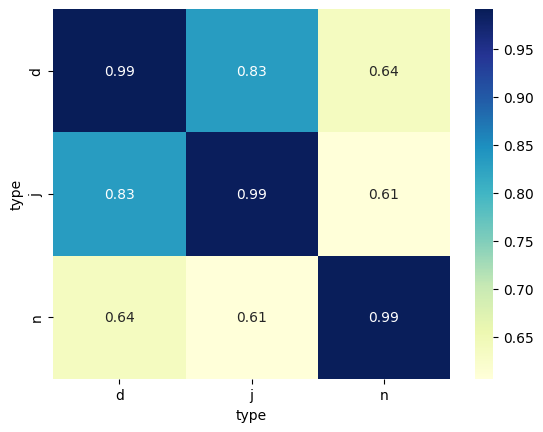

In [15]:
def magnitude(c):
    sum_squares = sum([x**2 for x in c])
    return math.sqrt(sum_squares)

def inner_product(x, y):
    return sum([x_i* y_i for x_i, y_i in zip(x, y)])

def cosine_similarity(x, y):
    return inner_product(x, y) / (magnitude(x) * magnitude(y))

def make_correlation_matrix(avg_per_char=False):
    correlations = pd.DataFrame(index=char_vectors['type'], columns=char_vectors['type'])
    
    for i, row_i in char_vectors.iterrows():
        for j, row_j in char_vectors.iterrows():
            correlations.at[f"{row_i['type']}", f"{row_j['type']}"] = cosine_similarity(row_i['vector'], row_j['vector'])
                
    if avg_per_char:
        correlations = correlations.groupby(lambda x: x[0]).mean().groupby(lambda x: x[0], axis=1).mean()
        
    return correlations

correlation_matrix = make_correlation_matrix(avg_per_char=True)
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap="YlGnBu")


From the heatmap can be seen the characters D and J are most similar, so thereby highest possibility to be confused

<Axes: xlabel='type', ylabel='type'>

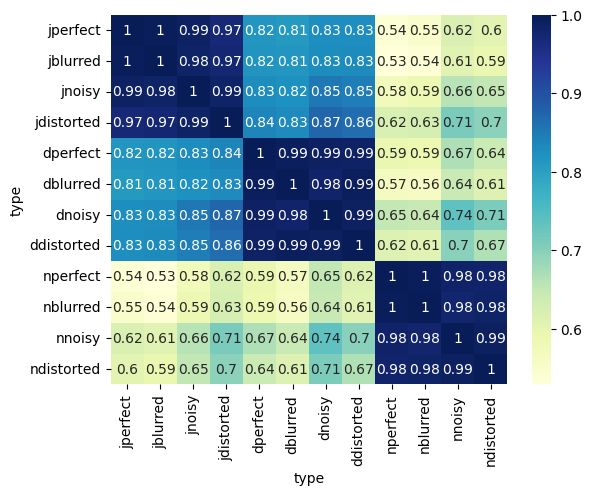

In [16]:
correlation_matrix = make_correlation_matrix()
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap="YlGnBu")

In the complete correlation matrix above can be seen that the correlation between d and j is very high (around 0.8) for perfect, noisy, blurred and both. Whereby the noisy of j and d is the highest combination of 0.88 cosine similarity. This will complicate the detection.

In [36]:
grouped_chars = char_vectors.groupby('character')['vector']
NN1 = np.array([])

for char in chars:
    stck = np.stack(grouped_chars.get_group(char).to_numpy()).mean(axis=0)
    NN1 = np.append(NN1, stck)
    
NN1.resize((3, 25))
print(NN1)

[[0.88875024 0.86192142 0.97868376 0.90219065 0.90834484 0.01341036
  0.04324621 0.12280612 0.12148525 0.90061355 0.11511087 0.06985111
  0.12760593 0.10571633 0.94780326 0.96992596 0.03834562 0.02600618
  0.06712761 0.88237326 0.06885262 0.9432894  0.89201658 0.97876103
  0.8983103 ]
 [0.86317874 0.8762679  0.98873553 0.97243879 0.07556859 0.95502628
  0.09270148 0.06443592 0.07948133 0.921898   0.85500364 0.07822612
  0.08008582 0.02082633 0.8850036  0.86263636 0.08467904 0.01760388
  0.0573322  0.88793023 0.91516197 0.9998459  0.86342193 0.87763841
  0.05766629]
 [0.93597203 0.097241   0.05198111 0.06623998 0.87209371 0.88141541
  0.87381048 0.09215805 0.03364354 0.95869583 0.92134681 0.11735141
  0.93637774 0.06055003 0.85754512 0.90192425 0.11948623 0.06259865
  0.90548822 0.96821571 0.89968792 0.06871643 0.10180359 0.07677412
  0.99846195]]


In [ ]:
# Multiply NN1 with the input vector 
input_vector = make_noisy(make_blurred(d_perfect, blur_level=0.38), noise_level=0.34)